In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from flight_plot_utils import load_csv, plot_angle, plot_rate
from sysid_utils import cost_2dof_integrator, sim_quadrotor_attitude, sysid_quadrotor_angle, slice_data
from linear_systems import linear_2dof_integrator

In [4]:
%matplotlib notebook

# Data Processing

In [5]:
# Load flight logs
flight_df = load_csv("flight_137")
flight_df.head(n=10)

,t,is_crashed,roll,pitch,yaw,p,q,r,throttle,p_cmd,...,pitch_pid_out,yaw_pid_out,motor_fl,motor_bl,motor_fr,motor_br,pwm_fl,pwm_bl,pwm_fr,pwm_br
0,7063,0,3.0625,0.5,-0.125,-0.06,-0.36,-2.315625,-1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
1,7075,0,0.0625,0.0,-0.125,-11.48,-1.74,-2.609531,-1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,819,819,819,819
2,7086,0,0.0625,0.0,-0.125,-0.06,0.53,-1.674226,-1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,819,819,819,819
3,7096,0,0.0625,0.0,-0.125,0.00,0.36,-0.321211,-1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,819,819,819,819
4,7108,0,0.0625,0.0,-0.125,0.18,0.12,1.112064,-1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,819,819,819,819
5,7120,0,0.0000,0.0,-0.125,-0.32,-0.24,1.896228,-1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,819,819,819,819
6,7131,0,0.0000,0.0,-0.125,-0.12,-0.18,1.104186,-1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,819,819,819,819
7,7141,0,0.0000,0.0,-0.125,0.00,-0.18,-0.063541,-1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,819,819,819,819
8,7151,0,0.0000,0.0,-0.125,0.00,0.00,-0.834427,-1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,819,819,819,819
9,7161,0,0.0000,0.0,-0.125,0.06,0.12,-1.526096,-1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,819,819,819,819


In [6]:
# Time - DF -> Numpy
t_df = flight_df['t']
t_np = t_df.to_numpy(dtype=np.int32)
t_np = t_np / 1000

# Crashed flag
crash_df = flight_df[['is_crashed']]
crash_np = crash_df.to_numpy()

# Roll / Pitch / Yaw - DF -> Numpy
rpy_df = flight_df[['roll', 'pitch', 'yaw']]
rpy_np = rpy_df.to_numpy()

# Roll / Pitch / Yaw Commands - DF -> Numpy
rpy_cmd_df = flight_df[['roll_cmd', 'pitch_cmd', 'yaw_cmd']]
rpy_cmd_np = rpy_cmd_df.to_numpy()

# Roll / Pitch / Yaw Rates - DF -> Numpy
pqr_df = flight_df[['p', 'q', 'r']]
pqr_np = pqr_df.to_numpy()

# PID Outputs - DF -> Numpy
pid_df = flight_df[['roll_pid_out', 'pitch_pid_out', 'yaw_pid_out', 'p_cmd', 'q_cmd', 'r_cmd']]
pid_np = pid_df.to_numpy()

# Motor % - DF -> Numpy
power_df = flight_df[['motor_fl', 'motor_bl', 'motor_fr', 'motor_br']]
power_np = power_df.to_numpy()

# Throttle - DF -> Numpy
throttle_df = flight_df['throttle']
throttle_np = throttle_df.to_numpy()

In [7]:
# Plotting indices
idx_start = 0
idx_end = np.size(t_np)

# Clip variables
t_clip = t_np[idx_start:idx_end]

In [8]:
""" 
Data clipping
"""

is_crash = crash_np[idx_start:idx_end]

roll = rpy_np[idx_start:idx_end, 0]
pitch = rpy_np[idx_start:idx_end, 1]
yaw = rpy_np[idx_start:idx_end, 2]

roll_cmd = rpy_cmd_np[idx_start:idx_end, 0]
pitch_cmd = rpy_cmd_np[idx_start:idx_end, 1]
yaw_cmd = rpy_cmd_np[idx_start:idx_end, 2]

p = pqr_np[idx_start:idx_end, 0]
q = pqr_np[idx_start:idx_end, 1]
r = pqr_np[idx_start:idx_end, 2]

p_pid = pid_np[idx_start:idx_end, 0]
q_pid = pid_np[idx_start:idx_end, 1]
r_pid = pid_np[idx_start:idx_end, 2]
roll_pid = pid_np[idx_start:idx_end, 3]
pitch_pid = pid_np[idx_start:idx_end, 4]
yaw_pid = pid_np[idx_start:idx_end, 5]

# Note: p,q,r cmds are the outer loop PID outputs.
p_cmd = roll_pid
q_cmd = pitch_pid
r_cmd = yaw_pid

# Roll SysID Analysis

<IPython.core.display.Javascript object>


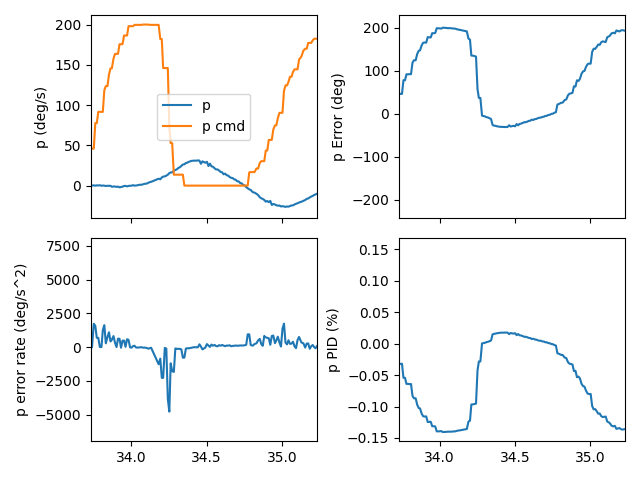

In [17]:
plot_rate(t_clip, p_cmd, p, np.gradient(p, t_clip), p_pid, "p")

<IPython.core.display.Javascript object>


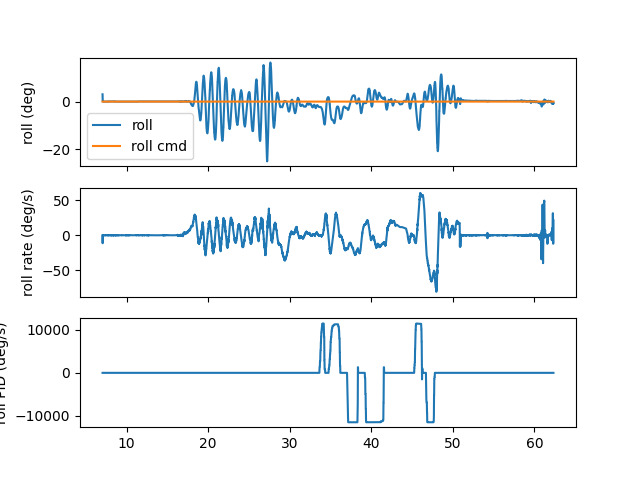

In [18]:
plot_angle(t_clip, roll_cmd, roll, p, np.degrees(roll_pid), label="roll")

In [39]:
roll_cols = ['t', 'roll', 'p', 'roll_pid_out']
roll_df = flight_df[roll_cols]

t_min = 33.6 * 1000
t_max = 34.3 * 1000

roll_slice = slice_data(roll_df, t_min, t_max)
roll_data = roll_slice.to_numpy()

# Convert t column from ms to sec
roll_data[:, 0] = roll_data[:, 0] / 1000

In [40]:
params = sysid_quadrotor_angle(roll_data, cost_2dof_integrator)

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
a     -1103    -2000        0     None     True     None     None
b    -493.8    -2000        0     None     True     None     None
c  1.887e+04      100    8e+05     None     True     None     None


Angle MSE (deg): 12.018005304542733
Rate MSE (deg): 33.466565552577194


<IPython.core.display.Javascript object>


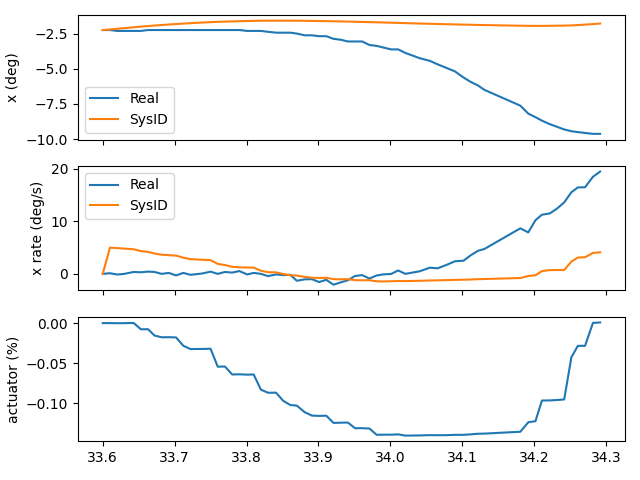

In [41]:
sim_quadrotor_attitude(roll_data, linear_2dof_integrator, params)

# Pitch Control

<IPython.core.display.Javascript object>


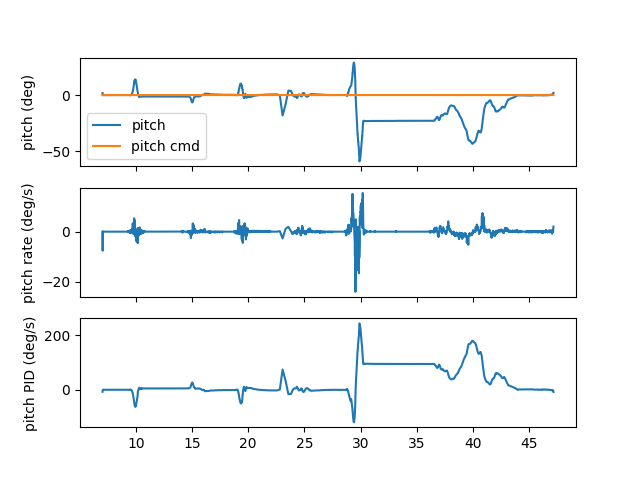

In [12]:
plot_angle(t_clip, pitch_cmd, pitch, q, np.degrees(pitch_pid), label="pitch")

# Yaw Control

<IPython.core.display.Javascript object>


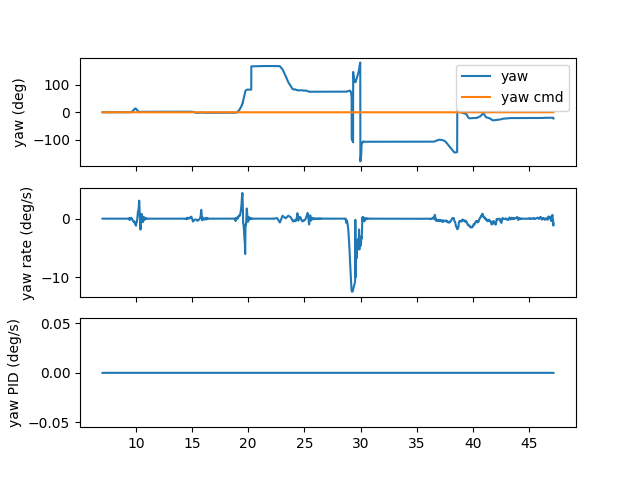

In [13]:
plot_angle(t_clip, yaw_cmd, yaw, r, yaw_pid, label="yaw")